
# **Lecture 5 Lab Notebook**

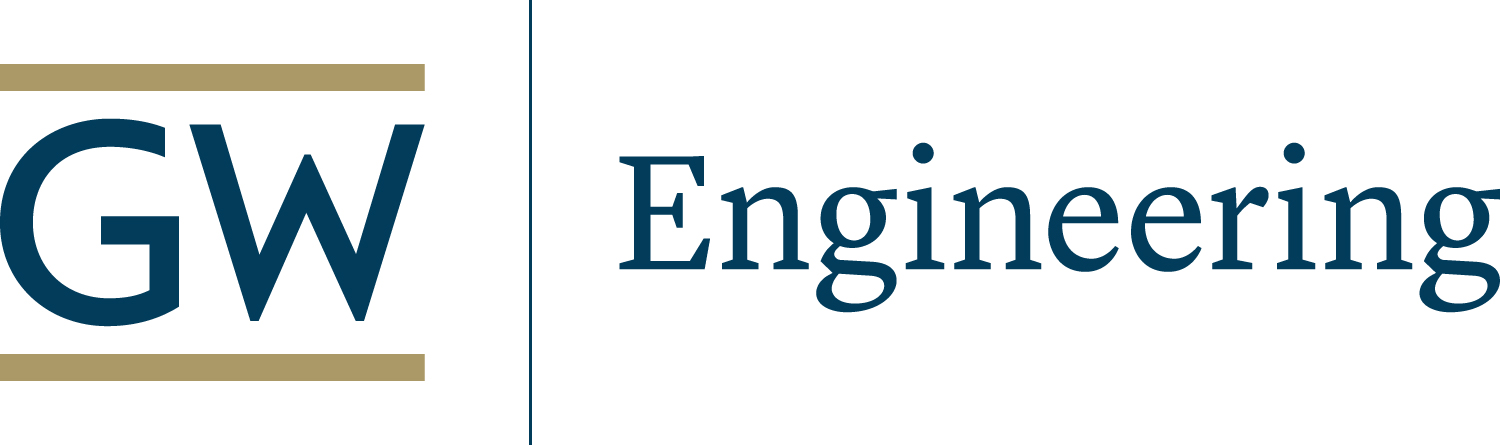

In [1]:
import subprocess
import sys

# List of required libraries
required_libraries = [
    'numpy',
    'pandas',
    'scikit-learn',
    'matplotlib',
    'seaborn'
]

# Function to install missing libraries
def install_libraries(libraries):
    for lib in libraries:
        try:
            # Try importing the library
            __import__(lib)
        except ImportError:
            print(f"{lib} not found. Installing...")
            if 'get_ipython' in globals():
                get_ipython().run_line_magic('pip', f'install {lib}')
            else:
                subprocess.check_call([sys.executable, '-m', 'pip', 'install', lib])

# Run the installation function
install_libraries(required_libraries)


scikit-learn not found. Installing...
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
import seaborn as sns

# scikit-learn models
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Evaluation and metrics
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    make_scorer,
    f1_score
)

# Data split and model selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Dimensionality reduction
from sklearn.decomposition import PCA

# Sample data generator
from sklearn.datasets import make_blobs



Lets generate some sythetic data to learn with

In [3]:
# # Parameters
# n_samples = 10000
# n_outliers = int(0.05 * n_samples)  # 5% outliers
# n_inliers = n_samples - n_outliers
# n_features = 20  # Number of features
# purturbation = 2
# # Generate inliers
# X_inliers, y_inliers = make_blobs(
#     n_samples=n_inliers, centers=3, n_features=n_features, cluster_std=1.5, random_state=42
# )

# # Generate outliers harder to detect (within the same distribution as inliers)
# X_outliers = X_inliers[np.random.choice(X_inliers.shape[0], n_outliers, replace=False)]
# X_outliers += np.random.normal(0, purturbation, size=X_outliers.shape)  # Slight random perturbation

# # Combine inliers and outliers
# X = np.vstack((X_inliers, X_outliers))
# y = np.hstack((np.zeros(n_inliers), np.ones(n_outliers)))  # 0 for inliers, 1 for outliers

# # Convert to DataFrame for exploration
# columns = [f"Feature{i+1}" for i in range(n_features)]
# df = pd.DataFrame(X, columns=columns)
# df["Class"] = y
# print(df.head())
# print(f"Shape of dataset: {df.shape}")


In [4]:
LABELS = ["Normal", "Fraud"]

In [5]:
df = pd.read_csv('../data/creditcard.csv')

In [19]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


C:\Users\cleme\AppData\Local\Temp\ipykernel_19352\2266408853.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


Text(0, 0.5, 'Frequency')

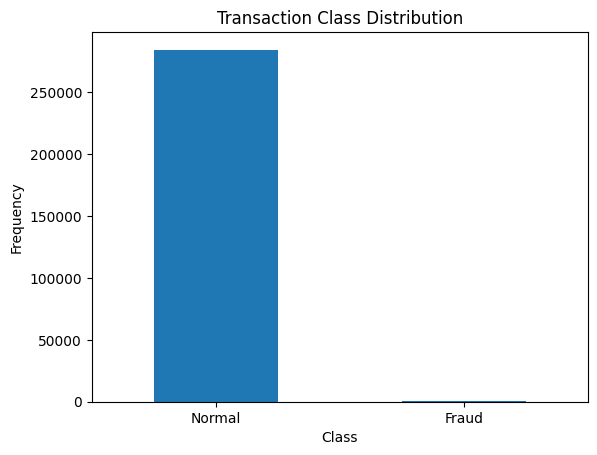

In [6]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [7]:
imbalance = (df['Class'] == 1).sum() / ((df['Class'] == 0).sum() + (df['Class'] == 1).sum())
print(f"The class imbalance is {imbalance}")

The class imbalance is 0.001727485630620034


In [8]:
X = df.drop(columns = 'Class')
y = df['Class']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) #stratify retains the class balance - important for imbalnced data

In [10]:
len(X_test)

85443

In [11]:
len(X_train)

199364

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # do not fit transform the test set.  only transform.

### The Problem of Information Leakage in Scaling

Information leakage happens when data from the test set influences the training process, 
leading to very optimistic model performance that doesn't generalize well to unseen data.

#### How Information Leakage Happens in Scaling
If the entire dataset is scaled before splitting into training and testing sets, the scaler
uses information from both sets (e.g., mean and standard deviation of the entire dataset). 
This introduces knowledge of the test data into the training process, potentially biasing 
the model's evaluation on the test data.

#### Solution
To prevent information leakage:
- The scaler should be fit only on the training set.
- The test set should be scaled using the parameters (mean and standard deviation) learned 
from the training set.
This approach ensures that the test set remains unseen during training, providing an accurate 
assessment of model performance.

In [ ]:
# Define the custom F1 scorer function (directly handle y_true and predictions)

from sklearn.metrics import f1_score, make_scorer

# Define the Isolation Forest model
iforest = IsolationForest()
# Define the One-Class SVM model
ocsvm = OneClassSVM()

# Use GridSearchCV with the custom F1 scorer
param_grid_iforest = {
    'n_estimators': [100],
    'max_samples': [0.75],
    'contamination': [.0001],
    'max_features': [.75]
}

# Define the parameter grid
param_grid_ocsvm = {
    'kernel': ['poly'],  # Different kernels
    'nu': [0.01],  # The fraction of outliers
    # 'gamma': [0.1, 1],  # Only for 'rbf' kernel
    'degree': [3],  # Only for 'poly' kernel
    'max_iter': [-1] #keep going till converges
}



In [14]:

def anomaly_f1_iforest(estimator, X, y_true):
    # IsolationForest returns 1 for inlier, -1 for outlier
    y_pred = estimator.predict(X)
    
    # Flip to 1 = anomaly, 0 = normal (to match y_true)
    y_pred = [1 if p == -1 else 0 for p in y_pred]
    
    return f1_score(y_true, y_pred)

def anomaly_f1_ocsvm(estimator, X, y_true):
    # OCSVM returns 1 for inlier, -1 for outlier
    y_pred = estimator.predict(X)
    
    # Flip to 1 = anomaly, 0 = normal (to match y_true)
    y_pred = [1 if p == -1 else 0 for p in y_pred]
    
    return f1_score(y_true, y_pred)


In [15]:
# Use it in GridSearchCV
# scorer_iforest = make_scorer(anomaly_f1_iforest)
# scorer_ocsvm = make_scorer(anomaly_f1_ocsvm)

In [16]:
# GridSearchCV for Isolation Forest
grid_iforest = GridSearchCV(iforest, param_grid_iforest, scoring=anomaly_f1_iforest, cv=5, verbose=2)
grid_iforest.fit(X_train_scaled, y_train)  # y must have 1 = anomaly, 0 = normal


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END contamination=0.01, max_features=0.75, max_samples=0.75, n_estimators=100; total time=  10.2s
[CV] END contamination=0.01, max_features=0.75, max_samples=0.75, n_estimators=100; total time=   9.5s
[CV] END contamination=0.01, max_features=0.75, max_samples=0.75, n_estimators=100; total time=   9.0s
[CV] END contamination=0.01, max_features=0.75, max_samples=0.75, n_estimators=100; total time=   9.0s
[CV] END contamination=0.01, max_features=0.75, max_samples=0.75, n_estimators=100; total time=   9.1s


GridSearchCV(cv=5, estimator=IsolationForest(),
             param_grid={'contamination': [0.01], 'max_features': [0.75],
                         'max_samples': [0.75], 'n_estimators': [100]},
             scoring=<function anomaly_f1_iforest at 0x0000026CA8BA59E0>,
             verbose=2)

In [17]:

grid_ocsvm = GridSearchCV(ocsvm, param_grid_ocsvm, scoring=anomaly_f1_ocsvm, cv=5, verbose=2)
grid_ocsvm.fit(X_train_scaled, y_train)  # y must have 1 = anomaly, 0 = normal


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ........degree=3, kernel=poly, max_iter=-1, nu=0.01; total time= 1.2min
[CV] END ........degree=3, kernel=poly, max_iter=-1, nu=0.01; total time= 1.8min
[CV] END ........degree=3, kernel=poly, max_iter=-1, nu=0.01; total time= 1.9min
[CV] END ........degree=3, kernel=poly, max_iter=-1, nu=0.01; total time= 1.7min
[CV] END ........degree=3, kernel=poly, max_iter=-1, nu=0.01; total time= 1.4min


GridSearchCV(cv=5, estimator=OneClassSVM(),
             param_grid={'degree': [3], 'kernel': ['poly'], 'max_iter': [-1],
                         'nu': [0.01]},
             scoring=<function anomaly_f1_ocsvm at 0x0000026CEDD107C0>,
             verbose=2)

In [20]:
best_model_iforest = grid_iforest.best_estimator_
best_model_ocsvm = grid_ocsvm.best_estimator_

# Output best parameters and best F1 score
print("Best iforest Parameters:", grid_iforest.best_params_)
print("Best iforest F1 Score:", grid_iforest.best_score_)

print("Best ocsvm Parameters:", grid_ocsvm.best_params_)
print("Best ocsvm F1 Score:", grid_ocsvm.best_score_)


Best iforest Parameters: {'contamination': 0.01, 'max_features': 0.75, 'max_samples': 0.75, 'n_estimators': 100}
Best iforest F1 Score: 0.20545210174488915
Best ocsvm Parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': -1, 'nu': 0.01}
Best ocsvm F1 Score: 0.0028629359286293592


In [21]:
grid_iforest.best_estimator_

IsolationForest(contamination=0.01, max_features=0.75, max_samples=0.75)

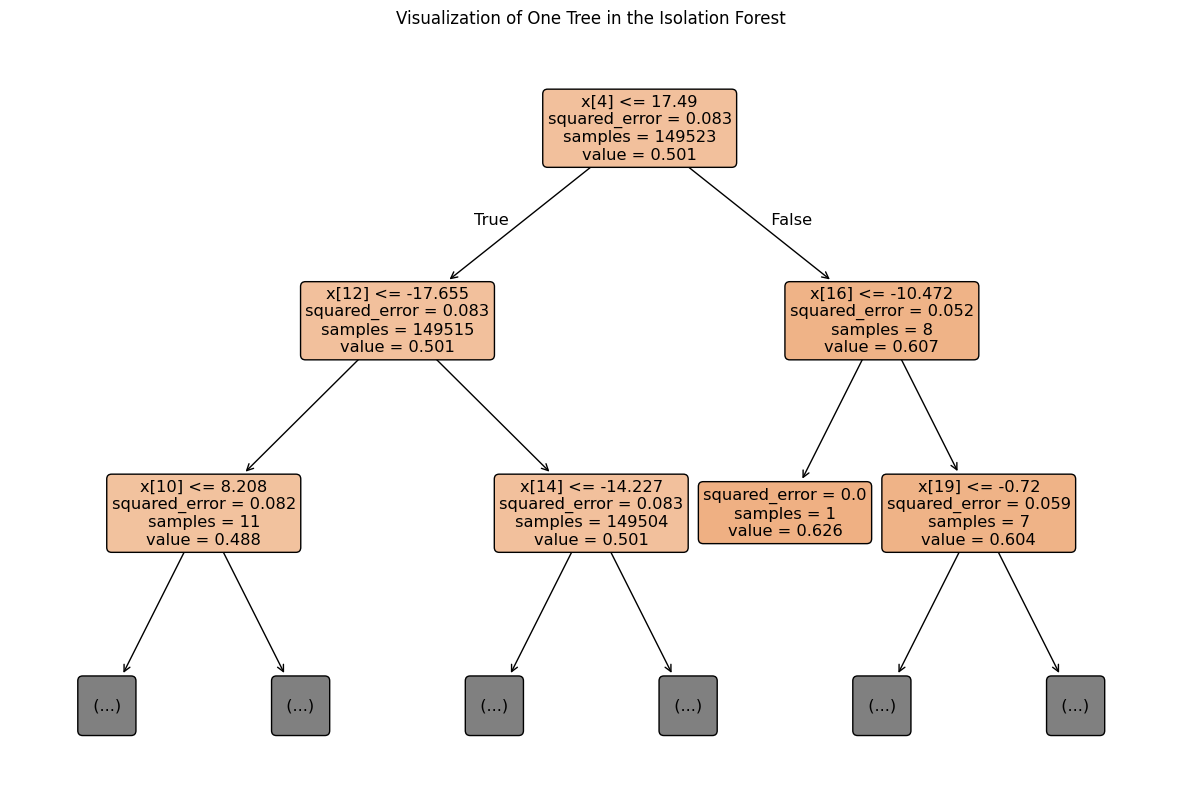

In [22]:
from sklearn.tree import plot_tree

tree = best_model_iforest.estimators_[0]  # Get the first tree

# Visualize the tree
plt.figure(figsize=(15, 10))
plot_tree(tree, filled=True, rounded=True, max_depth=2)
plt.title("Visualization of One Tree in the Isolation Forest")
plt.show()

Principal component analysis, or PCA, is a dimensionality reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize, and thus make analyzing data points much easier and faster for machine learning algorithms without extraneous variables to process.

https://builtin.com/data-science/step-step-explanation-principal-component-analysis

In [23]:
classifiers = {
    "Isolation Forest":best_model_iforest,
    "One Class SVM":best_model_ocsvm
}

Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.11      0.64      0.19       148

    accuracy                           0.99     85443
   macro avg       0.55      0.82      0.59     85443
weighted avg       1.00      0.99      0.99     85443



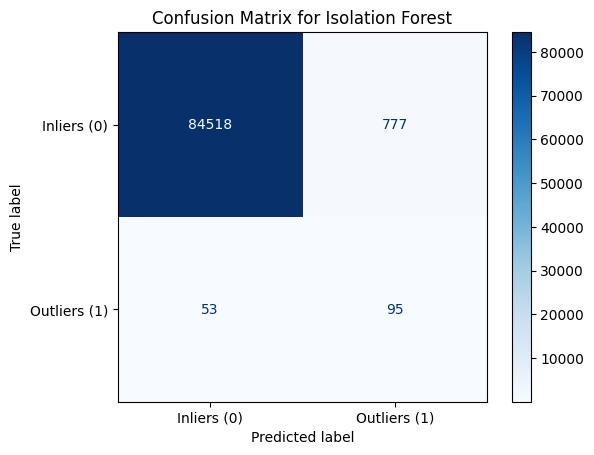

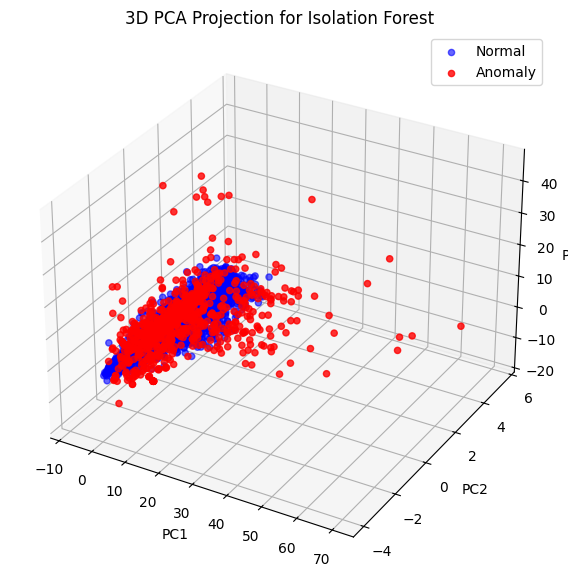

Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       0.00      0.01      0.00       148

    accuracy                           0.98     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      0.98      0.99     85443



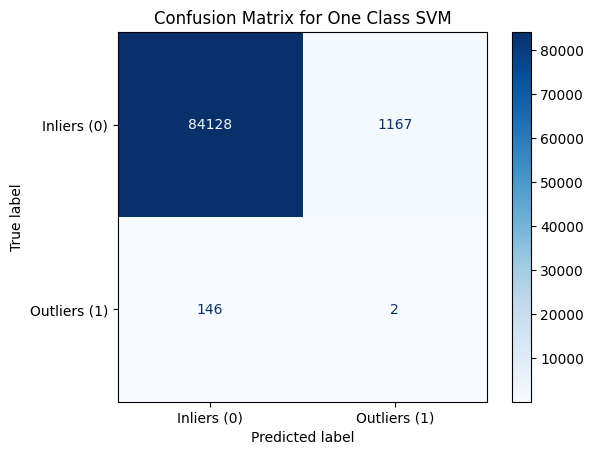

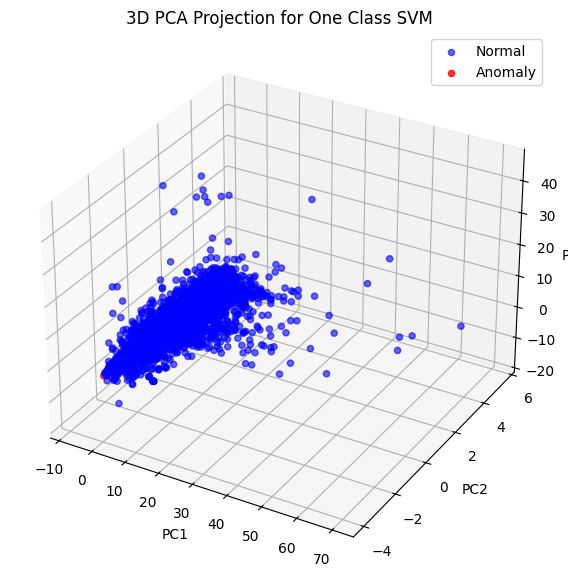

In [24]:
for i, (clf_name,clf) in enumerate(classifiers.items()):
    if (clf_name == "One Class SVM") or (clf_name == "Isolation Forest"):
        y_pred = clf.predict(X_test_scaled)
        y_pred = np.where(y_pred == 1, 0, 1)

    print("Classification Report :")
    print(classification_report(y_test,y_pred))

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Inliers (0)", "Outliers (1)"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix for {clf_name}")
    plt.show()

    # Reduce to 3D with PCA
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_test_scaled)

    # Split based on predicted labels
    normal = X_pca[y_pred == 0]
    anomaly = X_pca[y_pred == 1]

    # Plot in 3D
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(normal[:, 0], normal[:, 1], normal[:, 2], c='blue', label='Normal', alpha=0.6)
    ax.scatter(anomaly[:, 0], anomaly[:, 1], anomaly[:, 2], c='red', label='Anomaly', alpha=0.8)

    ax.set_title(f'3D PCA Projection for {clf_name}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.legend()
    plt.show()